In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nreldataset/3762824_38.38_-85.97_2024 copy.csv



Energy-Harvesting System Simulator 
==================================
Simulates a solar-powered IoT device with:
- Real NREL solar irradiance data input (CSV format)
- Supercapacitor energy storage
- Dynamic model switching (High/Degraded/Sleep modes)
- Buffer management for incoming data frames
- Voltage-based decision logic


# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Optional
from enum import Enum
import pandas as pd
from pathlib import Path
from datetime import datetime, timedelta

# Actions, Config and current simulation states

In [3]:
class Action(Enum):
    """Operating modes for the device"""
    HIGH = "HIGH"
    DEGRADED = "DEGRADED"
    SLEEP = "SLEEP"
    SLEEP_CRITICAL = "SLEEP_CRITICAL"
    SHUTDOWN = "SHUTDOWN"

In [12]:
@dataclass
class SimulationConfig:
    """Configuration parameters for the simulation"""
    
    # Time parameters
    dt: float = 0.1                          # Time step (s)
    total_time: float = 24 * 3600            # Total simulation time (s)
    
    # Supercapacitor parameters
    capacitance: float = 1.0                 # Farads
    v_init: float = 3.3                      # Initial voltage (V)
    v_max: float = 5.5                       # Maximum voltage (V)
    v_shutdown: float = 2.6                  # Shutdown threshold (V)
    v_warn: float = 2.9                      # Warning threshold (V)
    
    # Harvester (PV) parameters
    pv_area: float = 0.0025                  # Panel area (m²) - 25 cm²
    pv_efficiency: float = 0.18              # Conversion efficiency
    
    # Device load parameters
    v_supply: float = 3.3                    # Supply voltage (V)
    i_high: float = 8.0e-3                   # Current in HIGH mode (A)
    t_high: float = 0.2                      # Time per HIGH inference (s)
    i_degraded: float = 4.5e-3               # Current in DEGRADED mode (A)
    t_degraded: float = 0.1                  # Time per DEGRADED inference (s)
    i_sleep: float = 50e-6                   # Sleep current (A)
    i_baseline: float = 30e-6                # Baseline board current (A)
    e_checkpoint: float = 0.01               # Checkpoint energy (J)
    t_checkpoint: float = 0.05               # Checkpoint time (s)
    
    # Buffer parameters
    buffer_capacity: int = 30                # Maximum buffer size (frames)
    r_in: float = 2.0                        # Input rate (frames/s)
    frames_per_inference: int = 1            # Frames processed per inference
    
    # Decision thresholds
    v_high_safe: float = 4                 # Minimum for HIGH mode (V)
    v_degraded_safe: float = 2.9             # Minimum for DEGRADED mode (V)
    
    # PMIC efficiency (optional)
    pmic_efficiency: float = 0.85            # Power conversion efficiency

In [14]:
@dataclass
class SimulationState:
    """Current state of the simulation"""
    time: float = 0.0
    voltage: float = 0.0
    energy: float = 0.0
    buffer: float = 0.0
    action: Action = Action.SLEEP
    shutdown: bool = False
    
    # Cumulative metrics
    total_shutdowns: int = 0
    total_high_inferences: int = 0
    total_degraded_inferences: int = 0
    total_sleep_time: float = 0.0
    total_energy_harvested: float = 0.0
    total_energy_consumed: float = 0.0

In [6]:
# NREL DataLoader & Scenario Extraction

In [7]:
class NRELDataLoader:
    """
    Load and process NREL solar irradiance data
    """
    
    @staticmethod
    def load_nrel_csv(filepath: str, irradiance_column: str = 'GHI') -> pd.DataFrame:
        """
        Load NREL CSV data
        
        Expected columns: Timestamp, GHI (W/m²), DNI, DHI, Temperature, etc.
        
        Args:
            filepath: Path to NREL CSV file
            irradiance_column: Column name for irradiance ('GHI', 'DNI', or 'DHI')
            
        Returns:
            DataFrame with timestamp and irradiance
        """
        try:
            # Try reading with different encodings and skip rows
            df = pd.read_csv(filepath, skiprows=2)  # NREL files often have 2 header rows
            
            # Handle various timestamp formats
            if 'Year' in df.columns and 'Month' in df.columns:
                # NREL PSM format
                df['Timestamp'] = pd.to_datetime(
                    df[['Year', 'Month', 'Day', 'Hour', 'Minute']]
                )
            elif 'Timestamp' in df.columns:
                df['Timestamp'] = pd.to_datetime(df['Timestamp'])
            else:
                raise ValueError("Cannot find timestamp columns in NREL data")
            
            # Extract irradiance
            if irradiance_column not in df.columns:
                available = [col for col in df.columns if 'GHI' in col or 'DNI' in col or 'DHI' in col]
                raise ValueError(f"Column '{irradiance_column}' not found. Available: {available}")
            
            result = pd.DataFrame({
                'timestamp': df['Timestamp'],
                'irradiance': df[irradiance_column].astype(float)
            })
            
            # Remove any negative values (data quality flag)
            result.loc[result['irradiance'] < 0, 'irradiance'] = 0
            
            return result
            
        except Exception as e:
            raise RuntimeError(f"Error loading NREL data: {e}")
    
    @staticmethod
    def resample_to_timestep(df: pd.DataFrame, dt: float) -> np.ndarray:
        """
        Resample NREL data to simulation timestep
        
        Args:
            df: DataFrame with timestamp and irradiance
            dt: Simulation timestep (seconds)
            
        Returns:
            Array of irradiance values at simulation timestep
        """
        df = df.set_index('timestamp')
        
        # Resample to simulation timestep
        resampled = df['irradiance'].resample(f'{dt}S').interpolate(method='linear')
        
        return resampled.values
    
    @staticmethod
    def extract_scenario(df: pd.DataFrame, scenario_type: str) -> pd.DataFrame:
        """
        Extract specific scenario from NREL data
        
        Args:
            df: Full NREL DataFrame
            scenario_type: 'sunny_day', 'cloudy_day', 'partly_cloudy', 'winter_day', 'summer_day'
            
        Returns:
            DataFrame with selected day
        """
        df = df.copy()
        df['date'] = df['timestamp'].dt.date
        df['hour'] = df['timestamp'].dt.hour
        
        # Calculate daily statistics
        daily_stats = df.groupby('date').agg({
            'irradiance': ['mean', 'max', 'std']
        }).reset_index()
        daily_stats.columns = ['date', 'mean_irr', 'max_irr', 'std_irr']
        
        if scenario_type == 'sunny_day':
            # Find day with highest mean irradiance and low variance
            best_day = daily_stats.nlargest(10, 'mean_irr').nsmallest(1, 'std_irr')
            selected_date = best_day['date'].iloc[0]
            
        elif scenario_type == 'cloudy_day':
            # Find day with low mean and high variance
            cloudy_days = daily_stats[daily_stats['mean_irr'] < daily_stats['mean_irr'].quantile(0.3)]
            best_day = cloudy_days.nlargest(1, 'std_irr')
            selected_date = best_day['date'].iloc[0]
            
        elif scenario_type == 'partly_cloudy':
            # Medium irradiance with high variance
            medium_days = daily_stats[
                (daily_stats['mean_irr'] > daily_stats['mean_irr'].quantile(0.4)) &
                (daily_stats['mean_irr'] < daily_stats['mean_irr'].quantile(0.7))
            ]
            best_day = medium_days.nlargest(1, 'std_irr')
            selected_date = best_day['date'].iloc[0]
            
        elif scenario_type == 'winter_day':
            # Find day in Dec-Feb with good irradiance
            winter_mask = df['timestamp'].dt.month.isin([12, 1, 2])
            winter_stats = daily_stats[daily_stats['date'].isin(
                df[winter_mask]['date'].unique()
            )]
            best_day = winter_stats.nlargest(1, 'mean_irr')
            selected_date = best_day['date'].iloc[0]
            
        elif scenario_type == 'summer_day':
            # Find day in Jun-Aug with good irradiance
            summer_mask = df['timestamp'].dt.month.isin([6, 7, 8])
            summer_stats = daily_stats[daily_stats['date'].isin(
                df[summer_mask]['date'].unique()
            )]
            best_day = summer_stats.nlargest(1, 'mean_irr')
            selected_date = best_day['date'].iloc[0]
        
        else:
            raise ValueError(f"Unknown scenario type: {scenario_type}")
        
        # Extract the selected day
        
        selected_df = df[df['date'] == selected_date].copy()
        
        print(f"\n{scenario_type.upper()} Selected:")
        print(f"  Date: {selected_date}")
        print(f"  Mean irradiance: {selected_df['irradiance'].mean():.1f} W/m²")
        print(f"  Peak irradiance: {selected_df['irradiance'].max():.1f} W/m²")
        print(f"  Std deviation: {selected_df['irradiance'].std():.1f} W/m²")
        
        return selected_df[['timestamp', 'irradiance']].reset_index(drop=True)

# Simulator Class

In [8]:
class EnergyHarvestingSimulator:
    """
    Main simulator class for energy-harvesting IoT device
    """
    
    def __init__(self, config: SimulationConfig, irradiance_trace: np.ndarray, 
                 scenario_name: str = "Custom"):
        """
        Initialize simulator
        
        Args:
            config: Simulation configuration
            irradiance_trace: Array of irradiance values (W/m²) over time
            scenario_name: Name of scenario for reporting
        """
        self.config = config
        self.irradiance_trace = irradiance_trace
        self.scenario_name = scenario_name
        self.state = SimulationState()
        self.log: List[Dict] = []
        
        self._initialize_state()
    
    def _initialize_state(self):
        """Initialize the simulation state"""
        self.state.voltage = self.config.v_init
        self.state.energy = 0.5 * self.config.capacitance * self.config.v_init**2
        self.state.buffer = 0.0
        self.state.time = 0.0
    
    def _get_irradiance(self, time: float) -> float:
        """Get irradiance value at given time"""
        total_duration = self.config.total_time
        trace_length = len(self.irradiance_trace)
        idx = int((time / total_duration) * trace_length)
        idx = min(idx, trace_length - 1)
        return self.irradiance_trace[idx]
    
    def _compute_harvested_power(self, irradiance: float) -> float:
        """Compute power from solar panel"""
        return self.config.pv_efficiency * self.config.pv_area * irradiance
    
    def _select_action(self) -> Action:
        """Select action based on current state (rule-based controller)"""
        v = self.state.voltage
        buffer_available = self.state.buffer > 0
        
        if v >= self.config.v_high_safe and buffer_available:
            return Action.HIGH
        elif v >= self.config.v_degraded_safe and buffer_available:
            return Action.DEGRADED
        elif v >= self.config.v_warn:
            return Action.SLEEP
        else:
            return Action.SLEEP_CRITICAL
    
    def _compute_load_energy(self, action: Action) -> Tuple[float, float, int]:
        """Compute load energy, execution time, and frames processed"""
        cfg = self.config
        
        if action == Action.HIGH:
            energy = cfg.v_supply * cfg.i_high * cfg.t_high
            time = cfg.t_high
            frames = cfg.frames_per_inference
            
        elif action == Action.DEGRADED:
            energy = cfg.v_supply * cfg.i_degraded * cfg.t_degraded
            time = cfg.t_degraded
            frames = cfg.frames_per_inference
            
        elif action == Action.SLEEP:
            energy = cfg.v_supply * cfg.i_sleep * cfg.dt
            time = cfg.dt
            frames = 0
            
        elif action == Action.SLEEP_CRITICAL:
            energy = cfg.v_supply * (cfg.i_sleep / 10) * cfg.dt
            time = cfg.dt
            frames = 0
            
        else:  # SHUTDOWN
            energy = 0.0
            time = cfg.dt
            frames = 0
        
        # Add baseline board power
        e_baseline = cfg.v_supply * cfg.i_baseline * time
        energy += e_baseline
        
        return energy, time, frames
    
    def _update_capacitor(self, e_harv: float, e_load: float) -> Tuple[float, float]:
        """Update capacitor energy and voltage"""
        cfg = self.config
        
        e_new = self.state.energy + e_harv - e_load
        e_max = 0.5 * cfg.capacitance * cfg.v_max**2
        e_new = max(0.0, min(e_max, e_new))
        v_new = np.sqrt(2 * e_new / cfg.capacitance) if e_new > 0 else 0.0
        
        return e_new, v_new
    
    def _update_buffer(self, time_elapsed: float, frames_processed: int) -> float:
        """Update buffer occupancy"""
        cfg = self.config
        frames_in = cfg.r_in * time_elapsed
        buffer_new = self.state.buffer + frames_in - frames_processed
        buffer_new = max(0.0, min(cfg.buffer_capacity, buffer_new))
        return buffer_new
    
    def _check_shutdown(self, voltage: float) -> bool:
        """Check if system should shutdown"""
        return voltage < self.config.v_shutdown
    
    def step(self):
        """Execute one simulation time step"""
        cfg = self.config
        
        irradiance = self._get_irradiance(self.state.time)
        p_harv = self._compute_harvested_power(irradiance)
        e_harv = p_harv * cfg.dt * cfg.pmic_efficiency
        
        action = self._select_action()
        e_load, t_action, frames_proc = self._compute_load_energy(action)
        e_new, v_new = self._update_capacitor(e_harv, e_load)
        buffer_new = self._update_buffer(t_action, frames_proc)
        
        shutdown = self._check_shutdown(v_new)
        if shutdown:
            action = Action.SHUTDOWN
            v_new = cfg.v_shutdown
            self.state.total_shutdowns += 1
        
        self.state.total_energy_harvested += e_harv
        self.state.total_energy_consumed += e_load
        
        if action == Action.HIGH:
            self.state.total_high_inferences += frames_proc
        elif action == Action.DEGRADED:
            self.state.total_degraded_inferences += frames_proc
        elif action in [Action.SLEEP, Action.SLEEP_CRITICAL]:
            self.state.total_sleep_time += t_action
        
        self.log.append({
            'time': self.state.time,
            'irradiance': irradiance,
            'p_harv': p_harv,
            'voltage': self.state.voltage,
            'energy': self.state.energy,
            'action': action.value,
            'buffer': self.state.buffer,
            'shutdown': shutdown,
            'e_harv': e_harv,
            'e_load': e_load
        })
        
        self.state.time += cfg.dt
        self.state.voltage = v_new
        self.state.energy = e_new
        self.state.buffer = buffer_new
        self.state.action = action
        self.state.shutdown = shutdown
    
    def run(self) -> pd.DataFrame:
        """Run complete simulation"""
        print(f"\nRunning scenario: {self.scenario_name}")
        print(f"Duration: {self.config.total_time/3600:.1f} hours")
        
        steps = int(self.config.total_time / self.config.dt)
        for i in range(steps):
            self.step()
            if i % 10000 == 0:
                progress = 100 * i / steps
                print(f"Progress: {progress:.1f}%", end='\r')
        
        print("\nSimulation complete!")
        self._print_summary()
        
        return pd.DataFrame(self.log)
    
    def _print_summary(self):
        """Print simulation summary statistics"""
        cfg = self.config
        total_time_hours = cfg.total_time / 3600
        uptime = (cfg.total_time - self.state.total_sleep_time) / cfg.total_time * 100
        
        print("\n" + "="*60)
        print(f"SCENARIO: {self.scenario_name}")
        print("="*60)
        print(f"Total time:              {total_time_hours:.1f} hours")
        print(f"Final voltage:           {self.state.voltage:.2f} V")
        print(f"Final buffer:            {self.state.buffer:.1f} frames")
        print(f"Total shutdowns:         {self.state.total_shutdowns}")
        print(f"HIGH inferences:         {self.state.total_high_inferences}")
        print(f"DEGRADED inferences:     {self.state.total_degraded_inferences}")
        print(f"Active uptime:           {uptime:.1f}%")
        print(f"Energy harvested:        {self.state.total_energy_harvested:.2f} J")
        print(f"Energy consumed:         {self.state.total_energy_consumed:.2f} J")
        if self.state.total_energy_harvested > 0:
            eff = self.state.total_energy_consumed/self.state.total_energy_harvested*100
            print(f"Energy efficiency:       {eff:.1f}%")
        print("="*60)

# Results

In [9]:
def plot_results(df: pd.DataFrame, config: SimulationConfig, 
                scenario_name: str = "Simulation", save_path: str = None,
                max_points: int = 10000):
    """
    Plot simulation results safely and efficiently.
    
    Automatically downsamples large datasets to avoid renderer overload.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    # --- Safety: Downsample automatically if dataset is too large ---
    n_points = len(df)
    if n_points > max_points:
        factor = int(np.ceil(n_points / max_points))
        df = df.iloc[::factor, :].reset_index(drop=True)
        print(f"[Plot] Downsampled data from {n_points:,} to {len(df):,} points for plotting.")

    time_hours = df['time'] / 3600
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    
    # 1. Voltage over time
    ax = axes[0]
    ax.plot(time_hours, df['voltage'], linewidth=1.2, color='#2E86AB')
    ax.axhline(config.v_high_safe, color='green', linestyle='--', 
               label=f'HIGH threshold ({config.v_high_safe}V)', alpha=0.7)
    ax.axhline(config.v_degraded_safe, color='orange', linestyle='--', 
               label=f'DEGRADED threshold ({config.v_degraded_safe}V)', alpha=0.7)
    ax.axhline(config.v_shutdown, color='red', linestyle='--', 
               label=f'Shutdown ({config.v_shutdown}V)', alpha=0.7)
    ax.set_ylabel('Voltage (V)', fontsize=11, fontweight='bold')
    ax.set_title(f'Supercapacitor Voltage - {scenario_name}', fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # 2. Action timeline
    ax = axes[1]
    action_map = {'HIGH': 3, 'DEGRADED': 2, 'SLEEP': 1, 
                  'SLEEP_CRITICAL': 0.5, 'SHUTDOWN': 0}
    actions_numeric = df['action'].map(action_map)
    ax.fill_between(time_hours, 0, actions_numeric, alpha=0.6, step='post')
    ax.set_ylabel('Action', fontsize=11, fontweight='bold')
    ax.set_yticks([0, 0.5, 1, 2, 3])
    ax.set_yticklabels(['SHUTDOWN', 'CRITICAL', 'SLEEP', 'DEGRADED', 'HIGH'])
    ax.set_title('Operating Mode Timeline', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # 3. Buffer occupancy with irradiance overlay
    ax = axes[2]
    ax.plot(time_hours, df['buffer'], linewidth=1.2, color='#A23B72', label='Buffer')
    ax.axhline(config.buffer_capacity, color='red', linestyle='--', 
               label=f'Capacity ({config.buffer_capacity})', alpha=0.7)
    ax.set_ylabel('Buffer (frames)', fontsize=11, fontweight='bold', color='#A23B72')
    ax.tick_params(axis='y', labelcolor='#A23B72')
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Overlay irradiance
    ax2 = ax.twinx()
    ax2.plot(time_hours, df['irradiance'], linewidth=1.0, 
             color='#FFA500', alpha=0.5, label='Irradiance')
    ax2.set_ylabel('Irradiance (W/m²)', fontsize=11, fontweight='bold', color='#FFA500')
    ax2.tick_params(axis='y', labelcolor='#FFA500')
    ax2.legend(loc='upper right', fontsize=9)
    ax.set_title('Buffer Occupancy & Solar Irradiance', fontsize=12, fontweight='bold')
    
    # 4. Power flow
    ax = axes[3]
    p_load = df['e_load'] / config.dt
    ax.plot(time_hours, df['p_harv'], linewidth=1.0, 
            label='Harvested Power', color='#18A558', alpha=0.8)
    ax.plot(time_hours, p_load, linewidth=1.0, 
            label='Load Power', color='#F77F00', alpha=0.8)
    ax.set_ylabel('Power (W)', fontsize=11, fontweight='bold')
    ax.set_xlabel('Time (hours)', fontsize=11, fontweight='bold')
    ax.set_title('Power Flow', fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"[Plot] Figure saved to {save_path}")
    
    plt.show()


In [10]:
def compare_scenarios(results_dict: Dict[str, pd.DataFrame], config: SimulationConfig):
    """Compare multiple scenarios side-by-side"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    for scenario_name, df in results_dict.items():
        time_hours = df['time'] / 3600
        
        # Voltage comparison
        axes[0, 0].plot(time_hours, df['voltage'], linewidth=1.2, 
                       label=scenario_name, alpha=0.8)
        
        # Energy balance
        cumulative_harv = df['e_harv'].cumsum()
        cumulative_load = df['e_load'].cumsum()
        axes[0, 1].plot(time_hours, cumulative_harv, linewidth=1.2, 
                       label=f'{scenario_name} (Harvested)', linestyle='-', alpha=0.8)
        axes[0, 1].plot(time_hours, cumulative_load, linewidth=1.2, 
                       label=f'{scenario_name} (Consumed)', linestyle='--', alpha=0.8)
        
        # Irradiance profiles
        axes[1, 0].plot(time_hours, df['irradiance'], linewidth=1.2, 
                       label=scenario_name, alpha=0.8)
        
        # Buffer comparison
        axes[1, 1].plot(time_hours, df['buffer'], linewidth=1.2, 
                       label=scenario_name, alpha=0.8)
    
    # Format plots
    axes[0, 0].set_ylabel('Voltage (V)', fontweight='bold')
    axes[0, 0].set_title('Voltage Comparison', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].set_ylabel('Cumulative Energy (J)', fontweight='bold')
    axes[0, 1].set_title('Energy Balance', fontweight='bold')
    axes[0, 1].legend(fontsize=8)
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].set_xlabel('Time (hours)', fontweight='bold')
    axes[1, 0].set_ylabel('Irradiance (W/m²)', fontweight='bold')
    axes[1, 0].set_title('Irradiance Profiles', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].set_xlabel('Time (hours)', fontweight='bold')
    axes[1, 1].set_ylabel('Buffer (frames)', fontweight='bold')
    axes[1, 1].set_title('Buffer Occupancy', fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('scenario_comparison.png', dpi=300, bbox_inches='tight')
    print("Comparison plot saved to 'scenario_comparison.png'")
    plt.show()

# Main Excution

ENERGY HARVESTING SIMULATOR - NREL DATA SUPPORT

✓ Found NREL data file: /kaggle/input/nreldataset/3762824_38.38_-85.97_2024 copy.csv
Loading NREL solar irradiance data...

Extracting sunny_day...

SUNNY_DAY Selected:
  Date: 2024-07-07
  Mean irradiance: 347.7 W/m²
  Peak irradiance: 982.0 W/m²
  Std deviation: 379.0 W/m²


/tmp/ipykernel_37/2938743287.py:68: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  resampled = df['irradiance'].resample(f'{dt}S').interpolate(method='linear')



Running scenario: Sunny Day
Duration: 24.0 hours
Progress: 99.5%
Simulation complete!

SCENARIO: Sunny Day
Total time:              24.0 hours
Final voltage:           2.60 V
Final buffer:            30.0 frames
Total shutdowns:         193984
HIGH inferences:         246932
DEGRADED inferences:     15932
Active uptime:           52.9%
Energy harvested:        11570.25 J
Energy consumed:         1343.34 J
Energy efficiency:       11.6%
[Plot] Downsampled data from 864,000 to 9,932 points for plotting.
[Plot] Figure saved to plot_sunny_day.png


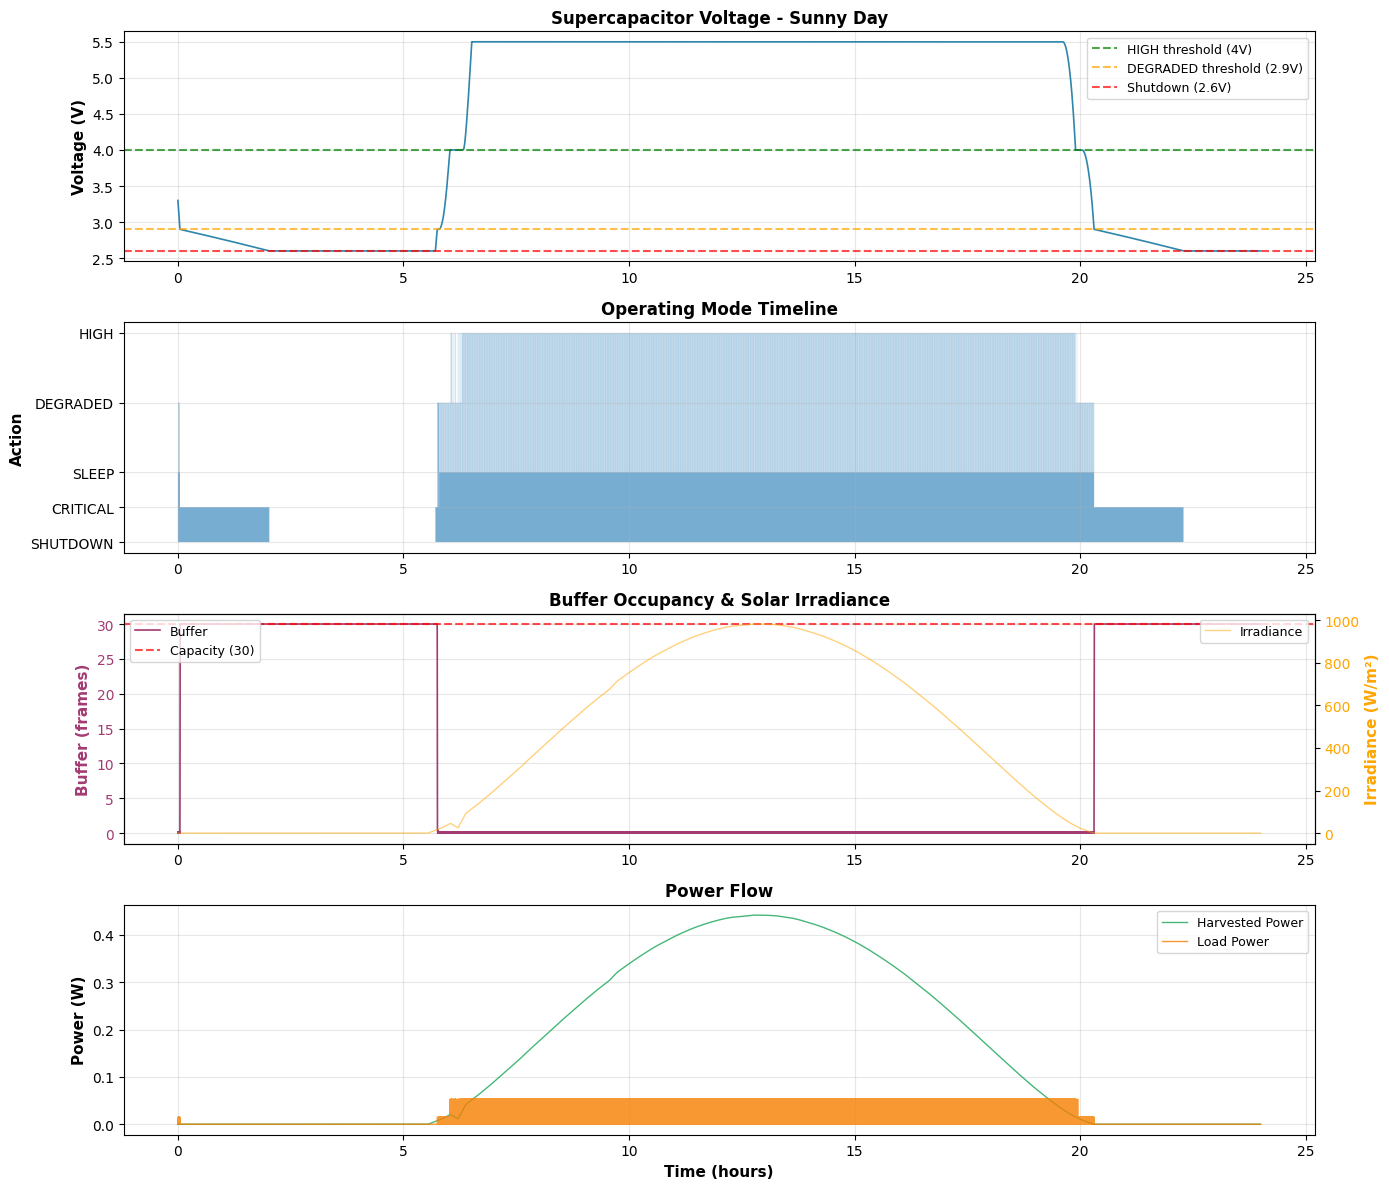


Extracting cloudy_day...

CLOUDY_DAY Selected:
  Date: 2024-04-02
  Mean irradiance: 102.0 W/m²
  Peak irradiance: 828.0 W/m²
  Std deviation: 192.3 W/m²


/tmp/ipykernel_37/2938743287.py:68: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  resampled = df['irradiance'].resample(f'{dt}S').interpolate(method='linear')



Running scenario: Cloudy Day
Duration: 24.0 hours
Progress: 99.5%
Simulation complete!

SCENARIO: Cloudy Day
Total time:              24.0 hours
Final voltage:           2.60 V
Final buffer:            30.0 frames
Total shutdowns:         267997
HIGH inferences:         148878
DEGRADED inferences:     68842
Active uptime:           56.2%
Energy harvested:        3395.62 J
Energy consumed:         902.55 J
Energy efficiency:       26.6%
[Plot] Downsampled data from 864,000 to 9,932 points for plotting.
[Plot] Figure saved to plot_cloudy_day.png


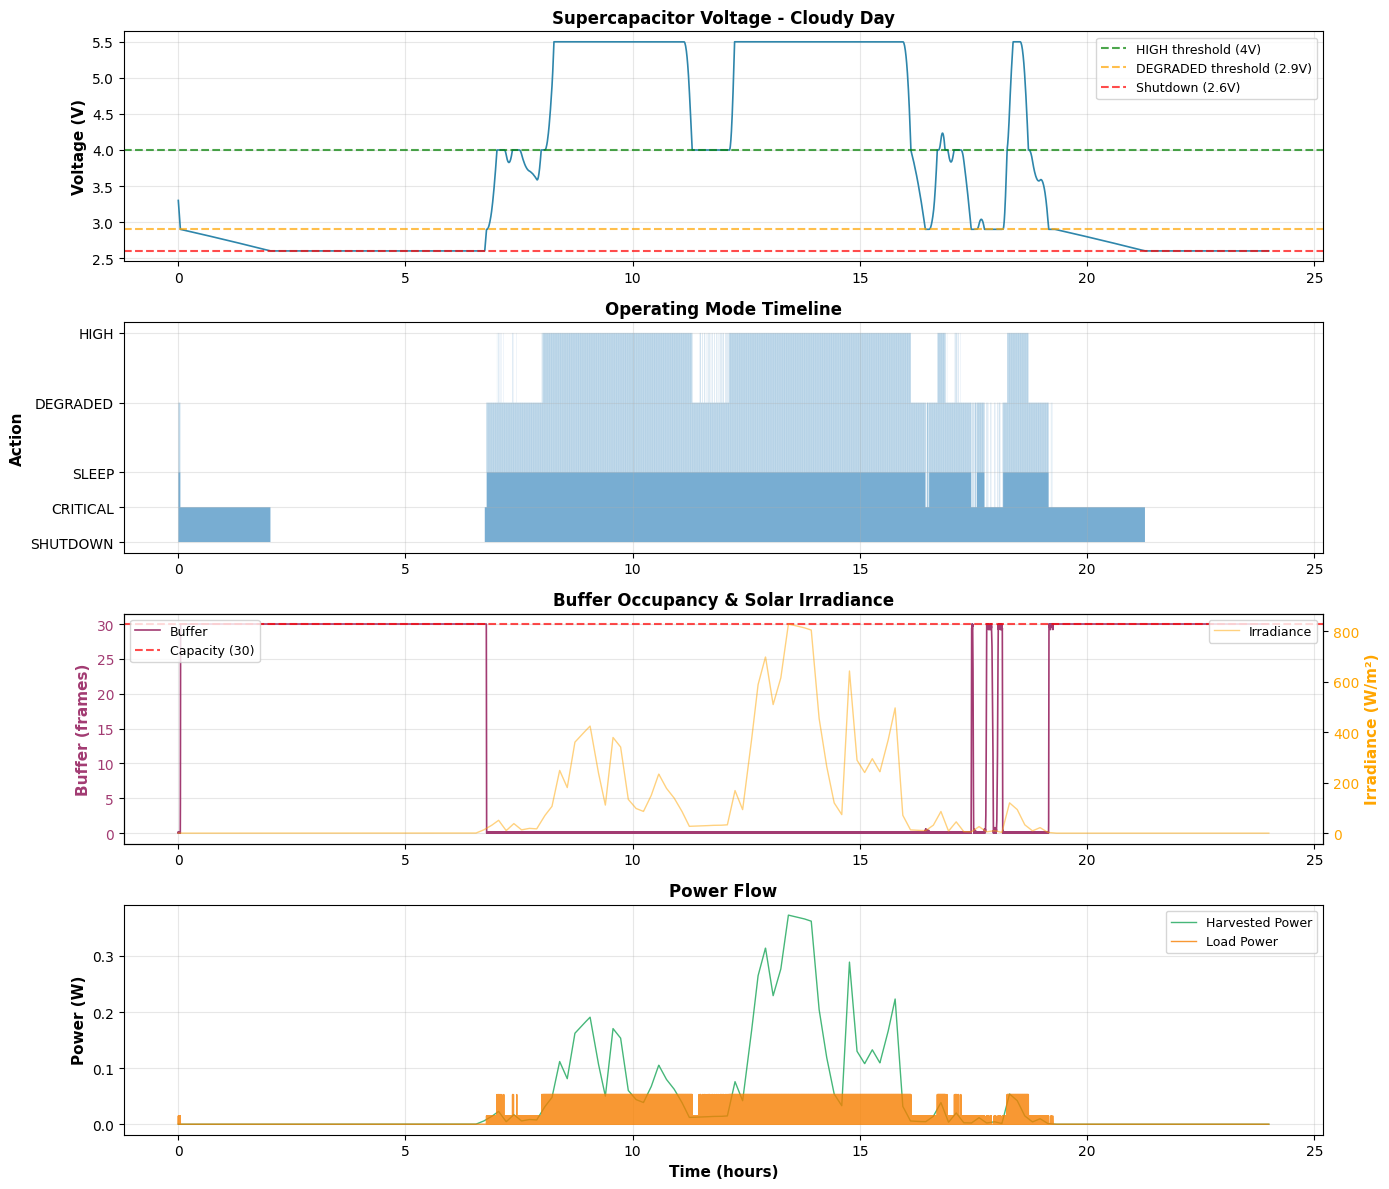


Extracting partly_cloudy...

PARTLY_CLOUDY Selected:
  Date: 2024-08-01
  Mean irradiance: 220.2 W/m²
  Peak irradiance: 910.0 W/m²
  Std deviation: 320.9 W/m²


/tmp/ipykernel_37/2938743287.py:68: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  resampled = df['irradiance'].resample(f'{dt}S').interpolate(method='linear')



Running scenario: Partly Cloudy
Duration: 24.0 hours
Progress: 99.5%
Simulation complete!

SCENARIO: Partly Cloudy
Total time:              24.0 hours
Final voltage:           2.60 V
Final buffer:            30.0 frames
Total shutdowns:         218718
HIGH inferences:         176347
DEGRADED inferences:     65153
Active uptime:           53.3%
Energy harvested:        7329.48 J
Energy consumed:         1042.67 J
Energy efficiency:       14.2%
[Plot] Downsampled data from 864,000 to 9,932 points for plotting.
[Plot] Figure saved to plot_partly_cloudy.png


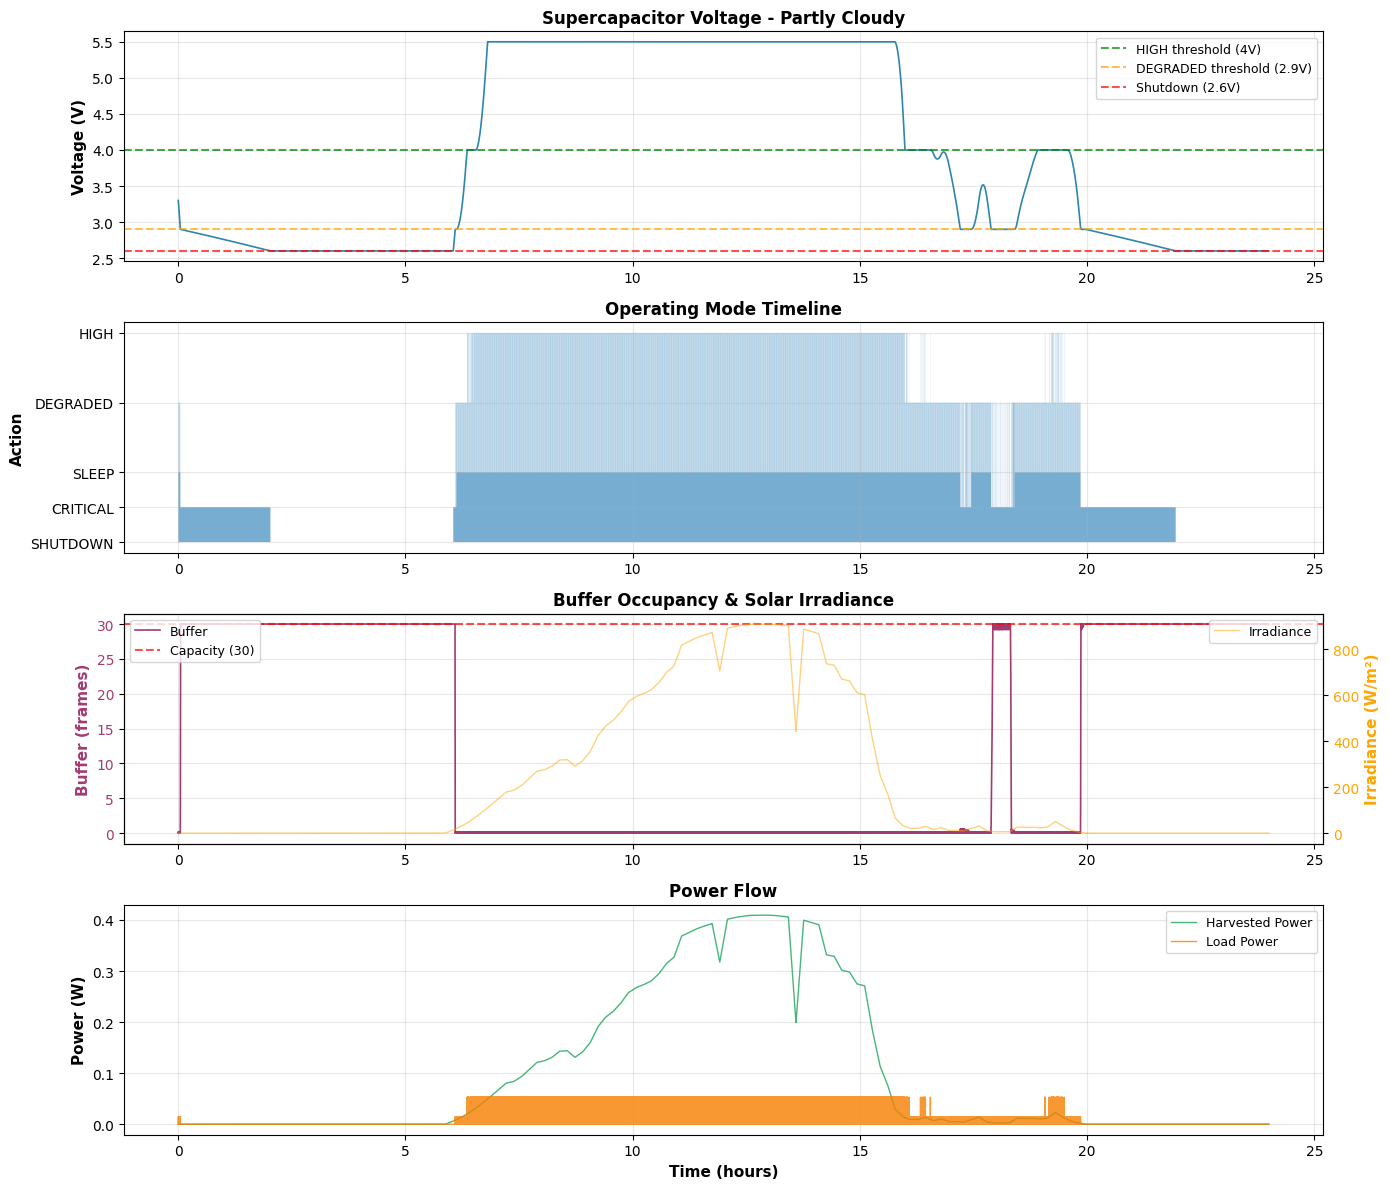


Generating scenario comparison...
Comparison plot saved to 'scenario_comparison.png'


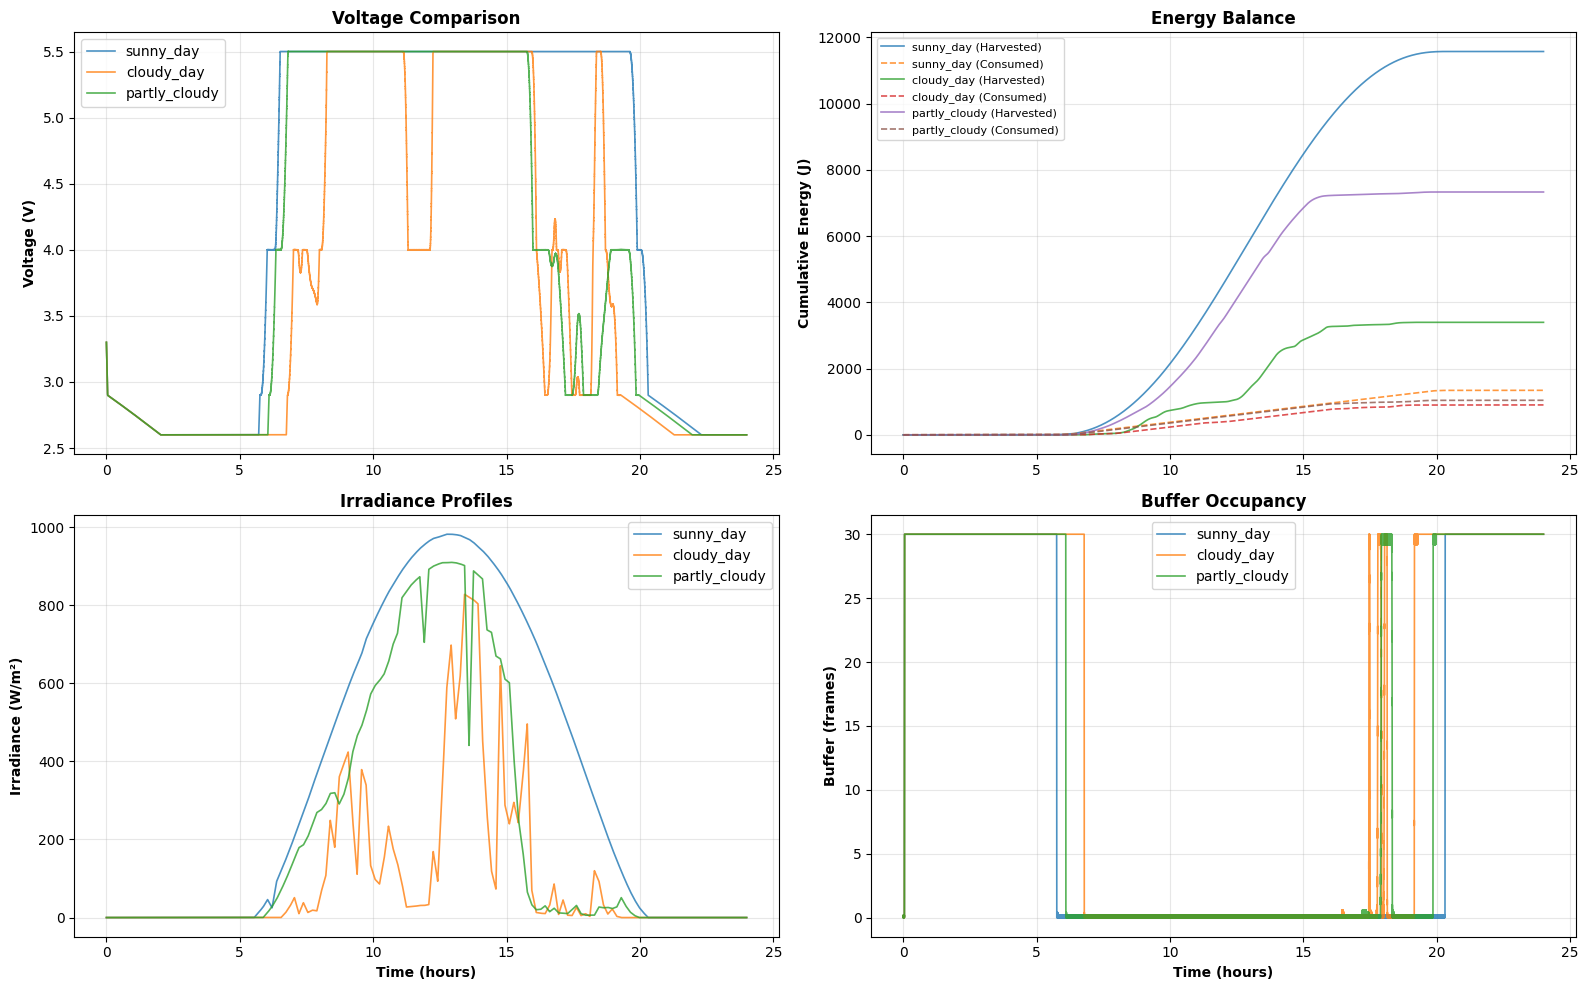


SIMULATION COMPLETE

Generated files:
  - Individual scenario results: results_*.csv
  - Individual scenario plots: plot_*.png
  - Scenario comparison: scenario_comparison.png


In [15]:
if __name__ == "__main__":
    # Configuration
    config = SimulationConfig(
        dt=0.1,
        total_time=24 * 3600,
        capacitance=1.0,
        v_init=3.3,
        pv_area=0.0025,
        pv_efficiency=0.18,
        i_baseline=30e-6  # Added baseline board current
    )
    
    print("="*70)
    print("ENERGY HARVESTING SIMULATOR - NREL DATA SUPPORT")
    print("="*70)
    
    # Try loading NREL data
    nrel_file = "/kaggle/input/nreldataset/3762824_38.38_-85.97_2024 copy.csv"
    use_nrel_data = Path(nrel_file).exists()
    
    if use_nrel_data:
        print(f"\n✓ Found NREL data file: {nrel_file}")
        print("Loading NREL solar irradiance data...")
        
        try:
            # Load full NREL dataset
            full_nrel_data = NRELDataLoader.load_nrel_csv(nrel_file, irradiance_column='GHI')
            
            # Extract different scenarios
            scenarios = {}
            scenario_types = ['sunny_day', 'cloudy_day', 'partly_cloudy']
            
            for scenario_type in scenario_types:
                print(f"\nExtracting {scenario_type}...")
                scenario_df = NRELDataLoader.extract_scenario(full_nrel_data, scenario_type)
                
                # Resample to simulation timestep
                irradiance_trace = NRELDataLoader.resample_to_timestep(scenario_df, config.dt)
                
                # Run simulation
                simulator = EnergyHarvestingSimulator(config, irradiance_trace, 
                                                     scenario_name=scenario_type.replace('_', ' ').title())
                results = simulator.run()
                
                # Save results
                results.to_csv(f'results_{scenario_type}.csv', index=False)
                
                # Plot individual scenario
                plot_results(results, config, scenario_name=scenario_type.replace('_', ' ').title(),
                           save_path=f'plot_{scenario_type}.png')
                
                scenarios[scenario_type] = results
            
            # Compare all scenarios
            print("\nGenerating scenario comparison...")
            compare_scenarios(scenarios, config)
            
        except Exception as e:
            print(f"\n✗ Error processing NREL data: {e}")
            print("Falling back to synthetic data...")
            use_nrel_data = False
    
    
    print("\n" + "="*70)
    print("SIMULATION COMPLETE")
    print("="*70)
    print("\nGenerated files:")
    print("  - Individual scenario results: results_*.csv")
    print("  - Individual scenario plots: plot_*.png")
    print("  - Scenario comparison: scenario_comparison.png")

    print("="*70)